In [10]:
using Revise
using PyPlot
using Infiltrator
using LinearAlgebra
using Bem2d
using PyCall

In [11]:
mu = 3e10
lambda = mu
nu = 0.25
rho = 2700
width = 10e3
g = 9.81
nels = 100
npts = 200
L = 1e4
offset = 100

100

In [12]:
top = 0
x, y = obsgrid(-L+offset, top-2*L+offset, L-offset, top-offset, npts) 
els = Elements(Int(1e5))
addelsez!(els, discretizedline(-L, top-2*L, L, top-2*L, nels)..., "B") # Bottom
addelsez!(els, discretizedline(L, top-2*L, L, top, nels)... , "R") # Right hand side
addelsez!(els, discretizedline(L, top, -L, top, nels)..., "T") # Top
addelsez!(els, discretizedline(-L, top, -L, top-2*L, nels)..., "L") # Left hand side

In [17]:
# Build BEM operator, TH
idx = getidxdict(els)
T_pU_qall, _ = PUTC(slip2dispstress, els, idx["B"], 1:1:els.endidx, mu, nu)
_, H_pT_qall = PUTC(slip2dispstress, els, [idx["R"] ; idx["T"]; idx["L"]], 1:1:els.endidx, mu, nu)
TH = [T_pU_qall ; H_pT_qall];

getidx found 100 elements with label "B"
getidx found 100 elements with label "R"
getidx found 100 elements with label "T"
getidx found 100 elements with label "L"


In [18]:
# Modified displacment BCs for bottom
Upart, _ = gravityparticularfunctions(els.xcenter[idx["B"]], els.ycenter[idx["B"]], g, rho, lambda, mu)
bcs = zeros(2 * els.endidx)
bcs[1:2:2*nels] = -Upart[:, 1]
bcs[2:2:2*nels] = -Upart[:, 2];

In [19]:
# Modified traction BCs for top
bcs[4*nels+2:2:6*nels] = -rho * g * (els.ycenter[idx["T"]] .* els.ynormal[idx["T"]])
Ueff = TH \ bcs;

In [20]:
# Forward solution on grid
Ucomp, _ = constdispstress(slip2dispstress, x, y, els, [idx["B"] ; idx["R"] ; idx["T"] ; idx["L"]],
                           Ueff[1:2:end], Ueff[2:2:end], mu, nu)
Uint, _ = gravityparticularfunctions(x, y, g, rho, lambda, mu)
Utotal = Ucomp .+ Uint
Umag = sqrt.(Utotal[:, 1].^2 + Utotal[:, 2].^2);

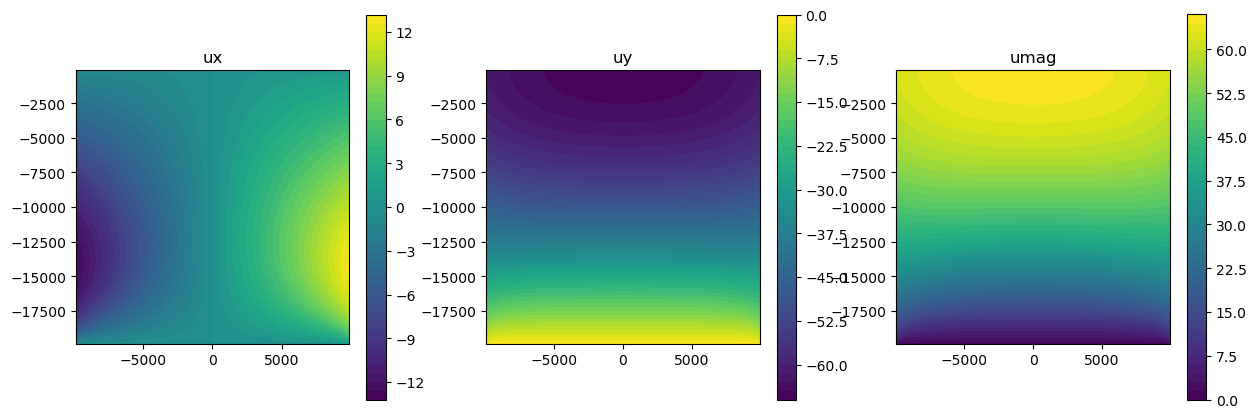

PyObject Text(0.5, 1.0, 'umag')

In [21]:
figure(figsize=(15, 5))

subplot(1, 3, 1)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Utotal[:, 1], npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("ux")

subplot(1, 3, 2)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Utotal[:, 2], npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("uy")

subplot(1, 3, 3)
contourf(reshape(x, npts, npts), reshape(y, npts, npts), reshape(Umag, npts, npts), 50)
colorbar()
gca().set_aspect("equal")
title("umag")